In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
alldata_df = pd.read_csv('all_stocks_5yr.csv')
alldata_df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [3]:
def relative_strength_index(stock, n = 14):
    
    difference = stock['close'].diff()
    up, down = difference.copy(), difference.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    rs = up.rolling(n).mean() / down.abs().rolling(n).mean()
    rsi = 100.0 - (100.0 / (1.0 + rs))
    
    return rsi

In [4]:
def average_directional_movement_index(stock, n=14, n_ADX=14):
    i = 0
    UpI = []
    DoI = []
    while i + 1 <= stock.index[-1]:
        UpMove = stock.loc[i + 1, 'high'] - stock.loc[i, 'high']
        DoMove = stock.loc[i, 'low'] - stock.loc[i + 1, 'low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    i = 0
    TR_l = [0]
    while i < stock.index[-1]:
        TR = max(stock.loc[i + 1, 'high'], stock.loc[i, 'close']) - min(stock.loc[i + 1, 'low'], stock.loc[i, 'close'])
        TR_l.append(TR)
        i = i + 1
    TR_s = pd.Series(TR_l)
    ATR = pd.Series(TR_s.ewm(span=n, min_periods=n).mean())
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean() / ATR)
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean() / ATR)
    ADX = pd.Series((abs(PosDI - NegDI) / (PosDI + NegDI)).ewm(span=n_ADX).mean())
    ADX = 100*ADX
    
    return ADX

In [5]:
def bollinger_bands(stock, n=14):
    
    MA = stock['close'].rolling(n).mean()
    MSD = stock['close'].rolling(n).std()
    bandwidth = 4 * MSD / MA * 100

    return bandwidth

In [263]:
def get_stock_indicators(stock):
    
    stock = stock.reset_index().drop(['index','Name'], axis = 1)

    #stock['dailyrange'] = ((stock['high'] - stock['low'] )/ stock['low'])*100

    #stock['dailychange'] = stock['close'].pct_change()

    #stock['sma10'] = stock.loc[:,'close'].rolling(window = 14).mean()

    stock['ema10'] = stock['close'].ewm(span = 14, adjust = False).mean()
    
    #stock['rsi'] = relative_strength_index(stock,14)
    
    #stock['adx'] = average_directional_movement_index(stock,14,14)
    
    #stock['bollingerbw'] = bollinger_bands(stock,14)

    return stock

In [254]:
def principal_components(stock, ticker = 'stockname_in_parameter'):
    
    stockvalues = stock.iloc[:,4:].dropna().values

    scaler = StandardScaler()

    stock_for_PCA = scaler.fit_transform(stockvalues)
      
    stock_pca = PCA(svd_solver = 'full').fit(stock_for_PCA)

    stock_pc = PCA(svd_solver = 'full', n_components = 1).fit_transform(stock_for_PCA)
    
    print('% Variance Explained for '+ ticker + ' = {}'.format(round(stock_pca.explained_variance_ratio_[0],2)))
    
    return stock_pc.reshape(len(stock_pc))

In [255]:
def principal_components_with_fitter(stock, fitter):
   
    '''
    Fits a given stock to the PCs of another stock to see similarity.
    Returns the transformed stock wrt the PC1 of the fitter stock.
    
    '''
    
    stockvalues = stock.iloc[:,4:].dropna().values

    scaler = StandardScaler()

    stock_for_PCA = scaler.fit_transform(stockvalues)
    
    stock_pc = fitter.transform(stock_for_PCA)[:,0]
    
    return stock_pc.reshape(len(stock_pc))

In [256]:
def min_sum_row(mat):  
    
    idx = -1000  
    minSum = 1000 

    for i in range(0, len(mat[0])):  
        summation = 0
        
        for j in range(0, len(mat)):  
            summation += mat[j][i]  
            
        if (summation < minSum): 
            minSum = summation  
            idx = i  
    return idx, minSum

In [257]:
def correlation_minimized_selection_algorithm(selected_stocks, n=20 , first_stock = 'FB'):
    
    correlations = []
    diverse_stocks = [first_stock]
    
    for i in range(n):
        if i==0:
            stock = selected_stocks[selected_stocks['Name'] == first_stock]
            current_stock = first_stock
        else:
            stock = selected_stocks[selected_stocks['Name'] == next_stock]
            current_stock = next_stock
        
        stock = get_stock_indicators(stock)
        stock_pc1 = principal_components(stock, current_stock)
        scaler = StandardScaler()
        stock_for_pca = scaler.fit_transform(stock.iloc[:,4:].dropna().values)


        transformed_stocks = pd.DataFrame(index = range(len(stock_pc1)), columns = [current_stock])
        transformed_stocks[current_stock] = stock_pc1

        tickers = selected_stocks['Name'].unique().tolist()

        fitter = PCA(svd_solver = 'full').fit(stock_for_pca)

        for ticker in tickers:
            stock = selected_stocks[selected_stocks['Name'] == ticker]

            stock = get_stock_indicators(stock)

            stock_pc = principal_components_with_fitter(stock, fitter)

            if len(stock_pc) != len(transformed_stocks):
                continue
            transformed_stocks[ticker] = stock_pc
        
        correlations.append(transformed_stocks.corr()[current_stock].sort_index().tolist())
        min_index, min_sum = min_sum_row(correlations)
        print('Sum of the correlations is {}'.format(round(min_sum,2)))
        correlations[0][min_index] = 100.0
        next_stock = transformed_stocks.corr()[current_stock].index[min_index]
        if next_stock in diverse_stocks:
            print('Not adding ' + next_stock + ' again')
            continue
        diverse_stocks.append(next_stock)
        print('Next Most Diverse Stock is '+next_stock)
        
    return diverse_stocks, correlations

In [248]:
def get_sharpe_ratio(portfolio_df, selected_stocks_variance_df, rfr = 2.5, weights = []):
    '''
    Takes in the portfolio dataframe and Risk Free Rate. Assigns risk free rate of 2.5% by default.
    Returns the sharpe ratio.   
    
    '''
    if len(weights) == 0:
        weights = len(portfolio_df) * [1/len(portfolio_df)]
    
    portfolio_return = get_portfolio_return(portfolio_df, weights)
    _, portfolio_std = get_portfolio_variance(portfolio_df, selected_stocks_variance_df, weights)
    
    sharpe_ratio = (portfolio_return - (rfr/100))/portfolio_std
    
    return sharpe_ratio

In [249]:
def get_portfolio_return(portfolio_df, weights = []):
    '''
    Takes in the portfolio dataframe and weights. Assigns uniform weights as default.
    Returns portfolio average yearly return.
    
    '''
    if len(weights) == 0:
        weights = len(portfolio_df) * [1/len(portfolio_df)]
    
    portfolio_return = sum( [a*b for a,b in zip(portfolio_df['yearly returns'].tolist(), weights)] )
    
    return portfolio_return

In [250]:
def get_portfolio_variance(portfolio_df, selected_stocks_variance_df, weights = []):
    if len(weights) == 0:
        weights = len(portfolio_df) * [1/len(portfolio_df)]
    
    weights = np.array(weights)
    
    cov = selected_stocks_variance_df[portfolio_df['tickers'].tolist()].loc[portfolio_df['tickers'].tolist()].values
    
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    
    portfolio_variance = portfolio_std**2
    
    return portfolio_variance, portfolio_std

In [251]:
def monte_carlo_portfolios(portfolio_df, selected_stocks_variance_df, rfr=2.5, number_of_trials = 1000):
    results = np.zeros((len(portfolio_df)+3, number_of_trials))
    for i in range(number_of_trials):
        weights = np.random.random(len(portfolio_df))
        weights /= np.sum(weights)
        p = get_portfolio_return(portfolio_df, weights)
        _,q = get_portfolio_variance(portfolio_df, selected_stocks_variance_df, weights)
        s = get_sharpe_ratio(portfolio_df, selected_stocks_variance_df, rfr, weights)
        results[0,i] = p
        results[1,i] = q
        results[2,i] = s
        for j in range(len(weights)):
            results[j+3,i] = weights[j]
    
    results_df = pd.DataFrame(results.T,columns=['returns','risk','sharpe ratio'] + [ticker for ticker in portfolio_df['tickers'].unique()])
    
    return results_df 

In [264]:
'''
This block basically takes only the stocks with over 10% or 15% returns and eliminates the rest.
The 15% data is already stored in the high_returns_df dataframe, which was stored in excel previously.
See the blogposttrial.ipynb for more info.

'''
high_returns_df = pd.read_excel('selected_stocks_15_percent_YoY.xlsx').dropna()

#high_returns_df = pd.read_excel('selected_stocks_10_percent_YoY.xlsx').dropna()

tickers = high_returns_df['tickers'].tolist()

selected_stocks = alldata_df[alldata_df['Name'] == tickers[0]]
for ticker in tickers[1:]:
    selected_stocks = pd.concat( [selected_stocks, alldata_df[alldata_df['Name'] == ticker] ] , axis = 0)
#selected_stocks = pd.concat( [selected_stocks, alldata_df[alldata_df['Name'] == 'WYNN'] ] , axis = 0)

#This part just removes incomplete data.
for ticker in selected_stocks['Name'].unique().tolist():
    if selected_stocks['Name'].value_counts()[ticker] != 1259:
        selected_stocks = selected_stocks[selected_stocks.Name != ticker]
selected_stocks['Name'].unique()

array(['AAL', 'AAPL', 'ABBV', 'ADBE', 'ADSK', 'AET', 'AGN', 'AIZ', 'ALGN',
       'ALK', 'ALL', 'AMAT', 'AMD', 'AMP', 'AMZN', 'ANTM', 'AON', 'AOS',
       'APH', 'ATVI', 'AVGO', 'AVY', 'AYI', 'BAC', 'BA', 'BBY', 'BDX',
       'BLK', 'BSX', 'CBOE', 'CDNS', 'CHTR', 'CI', 'CMA', 'CME', 'CNC',
       'COL', 'COO', 'CRM', 'CSX', 'CTAS', 'DAL', 'DHI', 'DLTR', 'DPS',
       'EA', 'EL', 'ETFC', 'EW', 'FB', 'FDX', 'FISV', 'FIS', 'GD', 'GILD',
       'GLW', 'GOOGL', 'GPN', 'GT', 'HAS', 'HBI', 'HCA', 'HD', 'HIG',
       'HII', 'HRS', 'HUM', 'IDXX', 'ILMN', 'INCY', 'INTU', 'ISRG', 'ITW',
       'IT', 'JPM', 'KEY', 'KR', 'LLL', 'LMT', 'LNC', 'LOW', 'LRCX',
       'LUV', 'MAR', 'MAS', 'MA', 'MCHP', 'MCO', 'MGM', 'MHK', 'MLM',
       'MMC', 'MMM', 'MNST', 'MSFT', 'MS', 'MTD', 'MU', 'NCLH', 'NDAQ',
       'NFLX', 'NKE', 'NOC', 'NVDA', 'ORLY', 'PCLN', 'PFG', 'PGR', 'PH',
       'PKG', 'PNC', 'RCL', 'REGN', 'RF', 'RHT', 'ROP', 'ROST', 'RTN',
       'SBAC', 'SCHW', 'SEE', 'SHW', 'SNA', 'SNPS', 'SPGI', 'S

In [265]:
'''
This block calculates the covariance matrix between the selected stocks
'''
price_df = pd.DataFrame(index = range(1259), columns = selected_stocks['Name'].unique())
for ticker in selected_stocks['Name'].unique():
    price_df[ticker] = selected_stocks[selected_stocks['Name'] == ticker]['close'].reset_index(drop = True)

selected_stocks_variance_df = price_df.pct_change().cov()
selected_stocks_variance_df.head()

,AAL,AAPL,ABBV,ADBE,ADSK,AET,AGN,AIZ,ALGN,ALK,...,VMC,VRSN,VRTX,V,WDC,WM,WYNN,XYL,ZION,ZTS
AAL,0.000504,0.000069,0.000085,0.000104,0.000156,0.000077,0.000106,0.000071,0.000105,0.000271,...,0.000114,0.000069,0.000125,0.000098,0.000138,0.000043,0.000110,0.000087,0.000119,0.000079
AAPL,0.000069,0.000213,0.000045,0.000065,0.000085,0.000044,0.000052,0.000036,0.000079,0.000070,...,0.000057,0.000054,0.000082,0.000061,0.000092,0.000034,0.000077,0.000052,0.000062,0.000049
ABBV,0.000085,0.000045,0.000284,0.000076,0.000087,0.000089,0.000121,0.000050,0.000111,0.000089,...,0.000074,0.000054,0.000146,0.000067,0.000084,0.000041,0.000092,0.000067,0.000075,0.000089
ADBE,0.000104,0.000065,0.000076,0.000235,0.000145,0.000069,0.000076,0.000051,0.000111,0.000088,...,0.000095,0.000075,0.000121,0.000099,0.000110,0.000044,0.000095,0.000077,0.000074,0.000064
ADSK,0.000156,0.000085,0.000087,0.000145,0.000352,0.000076,0.000082,0.000065,0.000117,0.000116,...,0.000108,0.000094,0.000152,0.000110,0.000154,0.000049,0.000131,0.000089,0.000111,0.000074


In [266]:
#First of 'seed' ticker = Facebook (FB)
diverse_stocks, correlations = correlation_minimized_selection_algorithm(selected_stocks, 10, 'NVDA')
diverse_stocks

% Variance Explained for NVDA = 0.78
Sum of the correlations is -0.28
Next Most Diverse Stock is GD
% Variance Explained for GD = 0.72
Sum of the correlations is -0.34
Next Most Diverse Stock is WYNN
% Variance Explained for WYNN = 0.73
Sum of the correlations is -0.24
Next Most Diverse Stock is KEY
% Variance Explained for KEY = 0.67
Sum of the correlations is 0.14
Next Most Diverse Stock is HAS
% Variance Explained for HAS = 0.67
Sum of the correlations is 0.58
Next Most Diverse Stock is AET
% Variance Explained for AET = 0.67
Sum of the correlations is 1.52
Next Most Diverse Stock is WDC
% Variance Explained for WDC = 0.75
Sum of the correlations is 1.51
Next Most Diverse Stock is AVY
% Variance Explained for AVY = 0.68
Sum of the correlations is 2.38
Next Most Diverse Stock is VMC
% Variance Explained for VMC = 0.73
Sum of the correlations is 3.2
Next Most Diverse Stock is RCL
% Variance Explained for RCL = 0.67
Sum of the correlations is 4.21
Not adding NVDA again


['NVDA', 'GD', 'WYNN', 'KEY', 'HAS', 'AET', 'WDC', 'AVY', 'VMC', 'RCL']

In [267]:
portfolio_df = high_returns_df
portfolio_df = portfolio_df[portfolio_df['tickers'].isin(diverse_stocks)].reset_index(drop = True)
portfolio_df
#portfolio_df = high_returns_df.sort_values('yearly returns', ascending = False)[0:5]
#portfolio_df

,tickers,yearly returns,yearly std,yearly variance
0,AET,0.249220,0.145594,0.021198
1,AVY,0.213252,0.206995,0.042847
2,GD,0.228399,0.174282,0.030374
3,HAS,0.180807,0.124381,0.015471
4,KEY,0.154297,0.185669,0.034473
5,NVDA,0.753270,0.733600,0.538169
6,RCL,0.271525,0.289416,0.083762
7,VMC,0.158993,0.165964,0.027544
8,WDC,0.158942,0.361642,0.130785
9,WYNN,0.183709,0.487589,0.237743


In [268]:
'''
This block gives the portfolio return, risk, and sharpe ratio is all assets in the portfolio have equal weight.
'''
p = get_portfolio_return(portfolio_df)
_,q = get_portfolio_variance(portfolio_df, selected_stocks_variance_df)
s = get_sharpe_ratio(portfolio_df, selected_stocks_variance_df, 2.5)

print('Portfolio Returns: {}%'.format(round(p*100,2)))
print('Portfolio Risk: {}%'.format(round(q*100,2)))
print('Portfolio Sharpe Ratio: {}'.format(round(s,2)))

Portfolio Returns: 25.52%
Portfolio Risk: 16.71%
Portfolio Sharpe Ratio: 1.38


In [269]:
results_df = monte_carlo_portfolios(portfolio_df, selected_stocks_variance_df, 2.5, 10000)

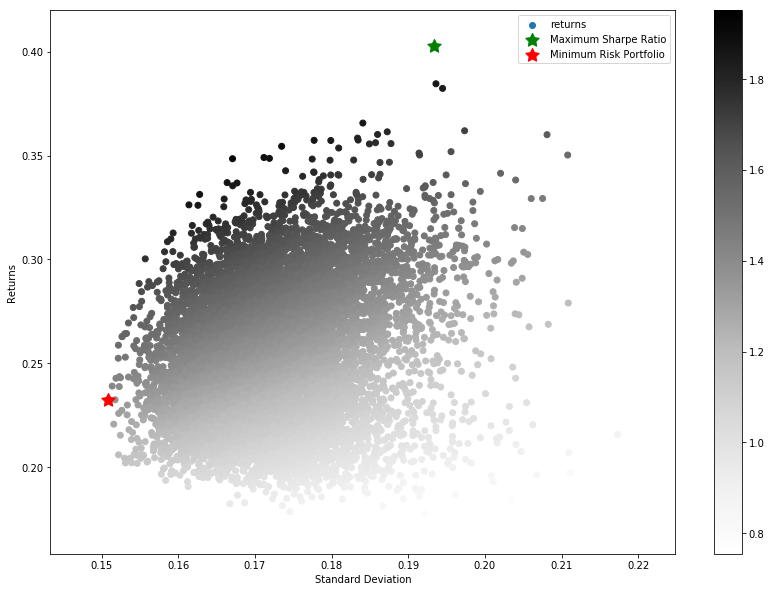

In [270]:
#Highest Sharpe Ratio Point
max_sharpe = results_df.iloc[results_df['sharpe ratio'].idxmax()]
#Minimum Risk Point
min_risk = results_df.iloc[results_df['risk'].idxmin()]

plt.subplots(figsize=(14,10))
plt.scatter(results_df['risk'], results_df['returns'], c = results_df['sharpe ratio'], cmap = 'Greys')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()

plt.scatter(max_sharpe[1], max_sharpe[0], marker=(5,1,0),color='green',s = 200, label = 'Maximum Sharpe Ratio')

plt.scatter(min_risk[1], min_risk[0], marker=(5,1,0),color='red',s = 200, label = 'Minimum Risk Portfolio')

plt.legend()

#plt.xlim([0.1,0.6])
#plt.ylim([0.1,0.9])

plt.show()